In [91]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Transforming and Splitting Data

In [92]:
df = pd.read_csv("data/combined_expression.csv")

In [93]:
df.head()

,CELL_LINE_NAME,classification,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,COL15A1,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1
0,1240121,5,6.419526,3.182094,9.320548,3.759654,3.802619,3.215753,4.698729,7.873672,...,3.245454,2.953508,3.543429,3.352022,4.672310,3.641128,3.135310,3.737072,3.450927,3.168800
1,1240122,6,7.646494,2.626819,10.153853,3.564755,3.942749,3.290760,3.551675,8.252413,...,2.786709,3.077382,3.728232,3.208882,4.586840,3.395654,3.586800,3.519128,3.115323,3.051645
2,1240123,5,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.459089,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022
3,1240124,1,9.006994,3.028173,9.686700,4.280504,3.147646,3.188881,3.293807,8.678790,...,2.835403,2.960303,3.415083,3.290171,4.770123,3.400821,3.383734,3.798107,2.822404,3.297547
4,1240127,6,7.985676,2.694729,10.676134,4.159685,3.804637,3.481942,3.111261,7.555407,...,2.896523,2.849899,3.480114,3.226128,5.832710,3.612179,3.347095,4.457963,5.198524,4.553586


In [94]:
X = df.drop(columns=['CELL_LINE_NAME', 'classification'])
y = df['classification']
feat_labels = list(X.columns)

In [95]:
# 20% test, 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Classifier With All Features

In [96]:
# create and train the classifier
clf = RandomForestClassifier(n_estimators=X.shape[1], random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16381,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [97]:
# associating each feature with its relative importance
feat_importances = list(zip(feat_labels, clf.feature_importances_))
feat_importances.sort(key = lambda x: x[1], reverse=True)

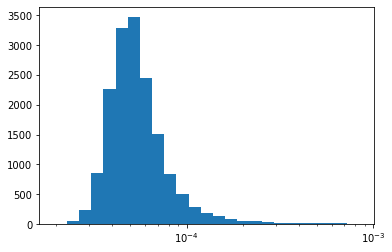

In [98]:
# plotting the feature importances
import matplotlib.pyplot as plt
indices = np.arange(len(feat_importances))
x, y = zip(*feat_importances)

def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')
plot_loghist(y, 25)

# Testing Various Thresholds
## Defining Functions for Multiple Iterations

In [99]:
def sfm_transforms(sfm, X_train, X_test):
    X_important_train = sfm.transform(X_train)
    X_important_test = sfm.transform(X_test)
    return X_important_train, X_important_test

In [100]:
def det_accuracy(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

## Testing Multiple Iterations

In [101]:
thresholds = np.linspace(5e-5, 1e-3, 15)
thresholds

array([5.00000000e-05, 1.17857143e-04, 1.85714286e-04, 2.53571429e-04,
       3.21428571e-04, 3.89285714e-04, 4.57142857e-04, 5.25000000e-04,
       5.92857143e-04, 6.60714286e-04, 7.28571429e-04, 7.96428571e-04,
       8.64285714e-04, 9.32142857e-04, 1.00000000e-03])

In [ ]:
thresh_accuracy = list()

j=1
for i in thresholds:
    sfm = SelectFromModel(clf, i)
    sfm.fit(X_train, y_train)
    X_important_train, X_important_test = sfm_transforms(sfm, X_train, X_test)

    clf_important = RandomForestClassifier(n_estimators=X.shape[1], random_state=0, n_jobs=-1)
    clf_important.fit(X_important_train, y_train)

    thresh_accuracy.append((i, det_accuracy(clf, X_test, y_test)))

    print(f'Iteration: {j}; threshold: {i}')
    j += 1

Iteration: 1; threshold: 5e-05
Iteration: 2; threshold: 0.00011785714285714286
Iteration: 3; threshold: 0.00018571428571428572
Iteration: 4; threshold: 0.0002535714285714286
Iteration: 5; threshold: 0.00032142857142857147
Iteration: 6; threshold: 0.0003892857142857143
Iteration: 7; threshold: 0.0004571428571428572


In [ ]:
thresh_accuracy

In [ ]:
# testList2 = [(np.log(elem1), elem2) for elem1, elem2 in thresh_accuracy]
plt.scatter(*zip(*thresh_accuracy))